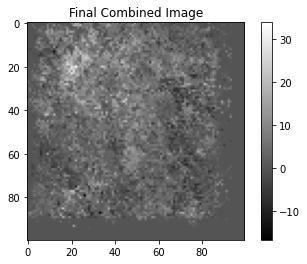

In [51]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 27 14:49:12 2024

@author: ChatGPT4
"""

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, shift, center_of_mass

# Load bad pixel mask
bad_pixels = np.loadtxt('badpixel.mask')

#values in this data run from 1 to 100 whereas indexes of the arrays they corrspeond to run from 0 to 99
for i in range(bad_pixels.shape[0]):
    for j in range(bad_pixels.shape[1]):
        bad_pixels[i,j] = bad_pixels[i,j]-1

def interpolate_bad_pixels(image, bad_pixels):
    """Interpolate bad pixels using the median of neighboring pixels."""
    for x, y in bad_pixels:
        image[int(x), int(y)] = np.median(image[max(0, int(x)-1):int(x)+2, max(0, int(y)-1):int(y)+2])
    return image

def remove_cosmic_rays(image, threshold=5000):
    """Remove cosmic ray hits by detecting and interpolating bright pixels."""
    cosmic_rays = np.where(image > threshold)
    for x, y in zip(*cosmic_rays):
        image[x, y] = np.median(image[max(0, x-1):x+2, max(0, y-1):y+2])
    return image

def subtract_sky(image):
    """Subtract the sky background by averaging non-object pixels."""
    # Masking bright sources (astronomical objects)
    sky_mask = image < np.percentile(image, 90)  # Adjust threshold as needed
    sky_background = np.mean(image[sky_mask])
    return image - sky_background

def find_centroid(image):
    """Find the centroid of the brightest object in the image."""
    threshold = np.percentile(image, 99)  # Assuming the object is one of the brightest points
    object_mask = image > threshold
    return center_of_mass(object_mask)

def process_image(image, bad_pixels):
    """Process a single image by applying bad-pixel interpolation, cosmic ray removal, and sky subtraction."""
    cleaned_image = interpolate_bad_pixels(image, bad_pixels)
    cleaned_image = remove_cosmic_rays(cleaned_image)
    sky_subtracted_image = subtract_sky(cleaned_image)
    return sky_subtracted_image

def combine_images(images):
    """Combine multiple images by taking the median value at each pixel."""
    return np.median(images, axis=0)

# Load and process all images
image_list = []
for i in range(1, 26):
    # Construct the filename (image01.fits to image25.fits)
    filename = f'image{i:02d}.fits'
    
    # Load the image
    image_data = fits.getdata(filename)

    # Process the image
    processed_image = process_image(image_data, bad_pixels)
    
    # Append the processed image to the list
    image_list.append(processed_image)

# Determine offsets and align images
aligned_images = []
reference_centroid = find_centroid(image_list[0])

for image in image_list:
    # Calculate the offset from the reference image
    centroid = find_centroid(image)
    offset = np.array(centroid) - np.array(reference_centroid)
    
    # Align the image
    aligned_image = shift(image, offset)
    aligned_images.append(aligned_image)

# Combine all aligned images
final_image = combine_images(aligned_images)

# Display the final combined image
plt.imshow(final_image, cmap='gray')
plt.colorbar()
plt.title('Final Combined Image')
plt.show()

# Optionally save the final image as a new FITS file
hdu = fits.PrimaryHDU(final_image)
hdu.writeto('final_combined_image.fits', overwrite=True)


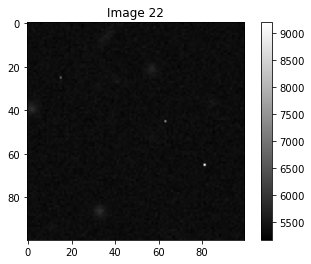

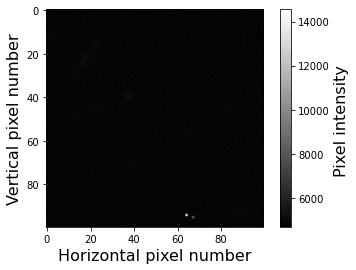

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, shift, center_of_mass

# Load bad pixel mask
bad_pixels = np.loadtxt('badpixel.mask')

#values in this data run from 1 to 100 whereas indexes of the arrays they corrspeond to run from 0 to 99
for i in range(bad_pixels.shape[0]):
    for j in range(bad_pixels.shape[1]):
        bad_pixels[i,j] = bad_pixels[i,j]-1

#creating array that will hold the 25 different 100x100 pixel images
image_list = np.zeros([25,100,100])

for i in range(1, 26):
    # Construct the filename (image01.fits to image25.fits)
    filename = f'image{i:02d}.fits'
    # Load the image
    image_data = fits.getdata(filename)
    
    for j in range(100):
        for k in range(100):
            image_list[i-1,j,k] = image_data[j,k]


#plotting two of the images to check my code has worked correctly and also to get an,
#, idea of what the images are of 
plt.imshow(image_list[21], cmap='gray')
plt.colorbar()
plt.title('Image 22')
plt.show()


plt.imshow(image_list[9], cmap='gray')
cbar = plt.colorbar()
cbar.set_label('Pixel intensity ', fontsize=16)
plt.xlabel('Horizontal pixel number', fontsize=16)
plt.ylabel('Vertical pixel number', fontsize=16)
#plt.title('Image 10')
plt.show()



plt.show()

In [2]:
#determining highest pixel value in an image - likely a cosmic ray 
ind1 = 0 #ind variable to store the vertical index of maximum value in the list
ind2 = 0 #same as before except now for the horizontal index
image_10 = image_list[9]
max_element = image_10[0,0]


for i in range (image_10.shape[0]):
    for j in range(image_10.shape[1]):
        if image_10[i,j] > max_element: #to keep replacing pixel when new brightest is found
            max_element = image_10[i,j]
            ind1 = i
            ind2 = j
print(ind1)
print(ind2)
print(image_10[ind1,ind2])
#code to manually check whether cosmic rays affect one pixel or group of neighbouring pixels 
for i in range(ind1-2,ind1+2):
    for j in range(ind2-2,ind2+2):
        print(image_10[i,j])

94
64
14551.7314453125
4915.75390625
4918.79931640625
4865.57861328125
4867.6826171875
4898.8701171875
4899.3857421875
4900.88720703125
4819.6474609375
4882.09765625
4974.7119140625
14551.7314453125
4848.30322265625
4822.4921875
4909.7392578125
4842.29296875
4908.04052734375


[[42. 70.]
 [18. 20.]
 [92. 70.]
 [59. 55.]
 [33. 69.]
 [45. 68.]
 [77. 59.]
 [70. 68.]
 [82. 67.]
 [94. 64.]
 [95. 68.]
 [20. 66.]
 [33. 66.]
 [19.  3.]
 [24. 38.]
 [70. 65.]
 [36.  8.]
 [42. 42.]
 [ 8. 64.]
 [54. 12.]
 [60. 46.]
 [65. 81.]
 [57. 62.]
 [77. 51.]
 [83. 85.]]
14481.0322265625
11230.462890625
8047.93701171875
12192.234375
12076.390625
9412.888671875
13492.4150390625
14145.953125
11483.599609375
14551.7314453125
12208.8359375
13479.4306640625
10915.4384765625
12871.58984375
9843.076171875
13021.482421875
14066.73828125
11122.5439453125
15193.6552734375
15203.2431640625
12228.5185546875
9195.4150390625
14561.056640625
13551.4013671875
10458.5048828125


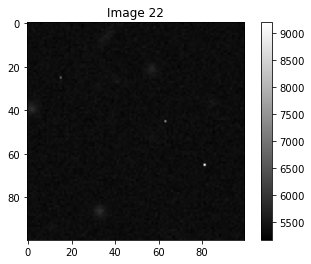

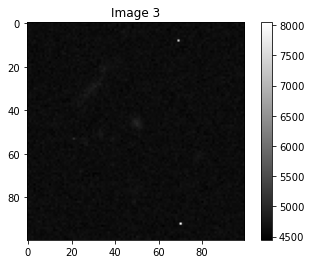

In [3]:
#changing code to check highest pixel inensity in all images not just one

element_storer = np.zeros([25, 2])

for k in range(25):
    
    max_element = image_list[k,0,0]
    
    for i in range (image_10.shape[0]):
        for j in range(image_10.shape[1]):
            if image_list[k,i,j] > max_element: #to check max value
                max_element = image_list[k,i,j]
                element_storer[k,0] = i
                element_storer[k,1] = j

print(element_storer)

for k in range(element_storer.shape[0]):
    a = int(element_storer[k,0])
    b = int(element_storer[k,1])
    print(image_list[k,a,b])


plt.imshow(image_list[21], cmap='gray')
plt.colorbar()
plt.title('Image 22')
plt.show()


plt.imshow(image_list[2], cmap='gray')
plt.colorbar()
plt.title('Image 3')
plt.show()


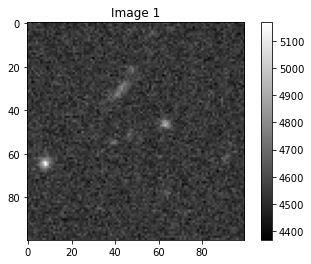

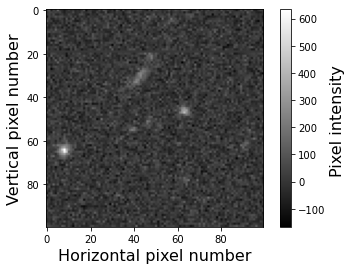

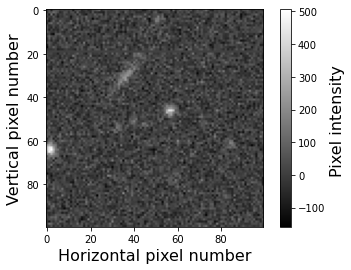

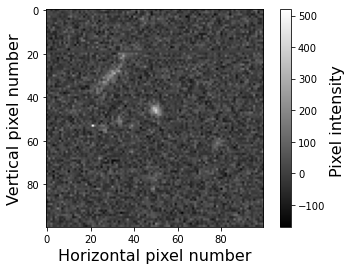

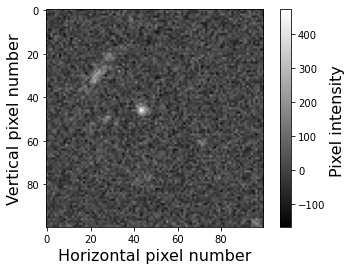

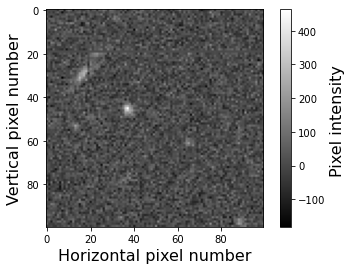

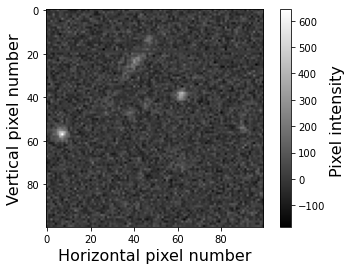

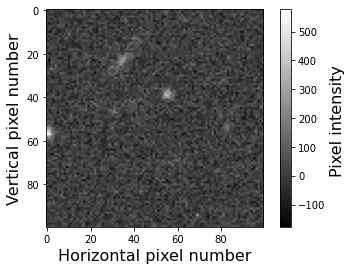

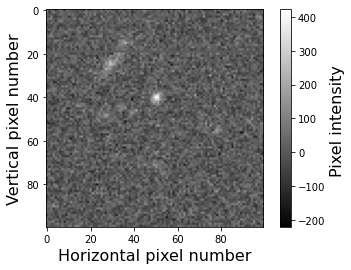

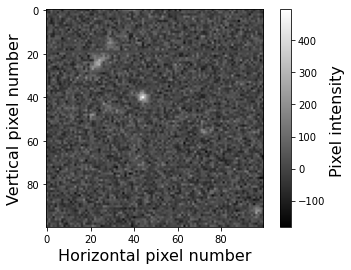

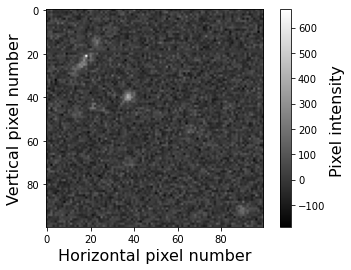

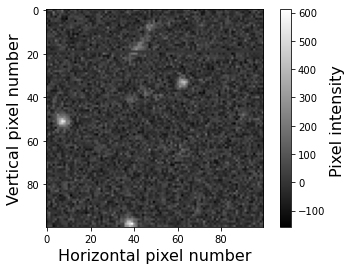

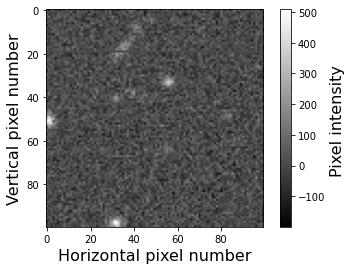

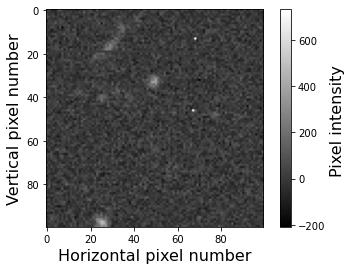

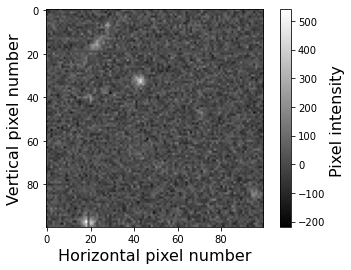

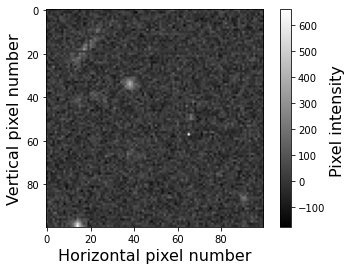

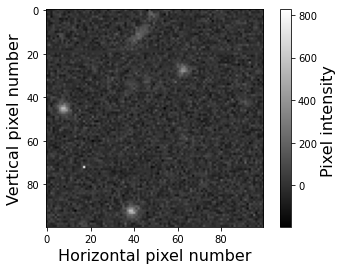

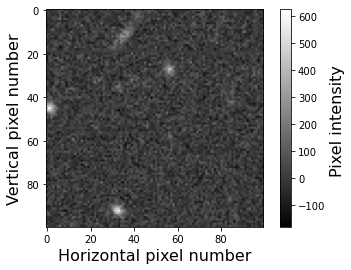

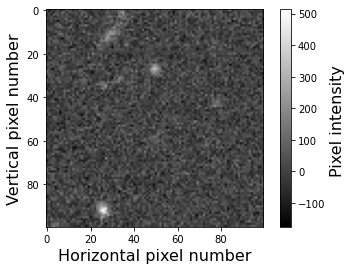

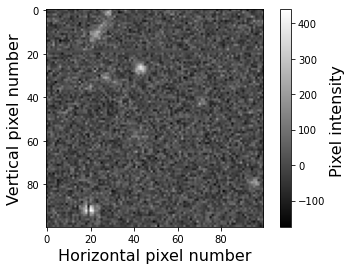

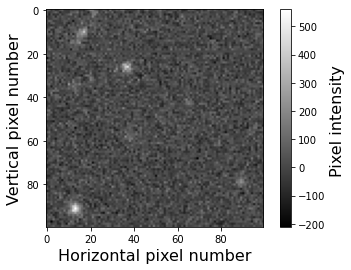

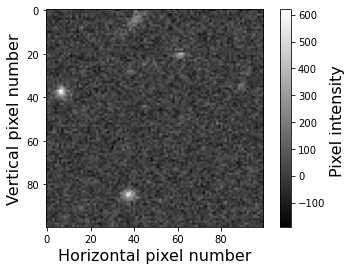

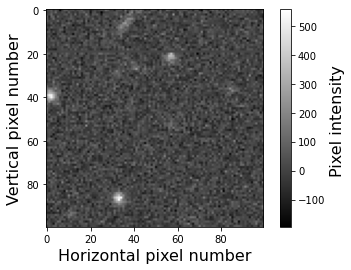

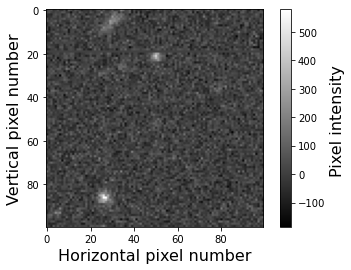

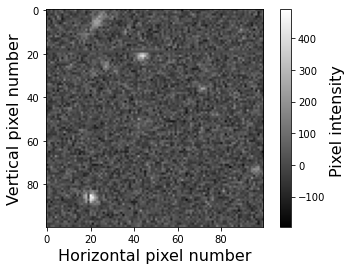

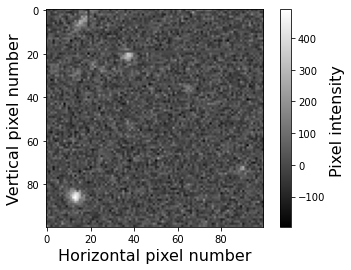

In [4]:


#Removing bad pixels 
for i in range(25):
    for x, y in bad_pixels: 
        if x == 19:
            image_list[i,int(x), int(y)] = np.median(image_list[i,max(0, int(y)-2):int(y)+3])
#if x=19 the code only averages the pixels in vertical slice around the bad pixel, 
#, as x =19 is a row of bad pixels so dont want to average using horizontally , 
#, neighbouring bad pixels
        else:
            image_list[i,int(x), int(y)] = np.median(image_list[i,max(0, int(x)-1):int(x)+2, max(0, int(y)-1):int(y)+2])

            
#Removing cosmic ray (CR) pixels 
threshold = 6000 #originally determined by smallest of the max pixel values, 
#, but this left some cosmic ray pixels still present so had to be lowered 
for i in range(25):
    for j in range(100):
        for k in range(100):
            if image_list[i,j,k] > threshold:
                neighborhood = image_list[i, max(0, j-1):min(100, j+2), max(0, k-1):min(100, k+2)] #ensures code does not check outside the image
                image_list[i, j, k] = np.median(neighborhood) #takes average value of region to assign to CR pixel


plt.imshow(image_list[0], cmap='gray')
plt.colorbar()
plt.title('Image 1')
plt.show()  

#Removing the background sky
for i in range(25):
    percent_90 = np.percentile(image_list[i], 90) #gives intensity vlaue that 90% of the pixels fall under (dark background sky)
    sky_mask = image_list[i] < percent_90 
    sky_background = np.mean(image_list[i,sky_mask]) #calculates the average intensity of the background sky 
    image_list[i] = image_list[i] -sky_background    


def process_image(image, bad_pixels):
    """Process a single image by applying bad-pixel interpolation, cosmic ray removal, and sky subtraction."""
    cleaned_image = interpolate_bad_pixels(image, bad_pixels)
    
    return cleaned_image


#Plots all the images to check code has worked as expected 
for i in range(25):
    plt.imshow(image_list[i], cmap='gray')
    cbar = plt.colorbar()
    cbar.set_label('Pixel intensity ', fontsize=16)
    plt.xlabel('Horizontal pixel number', fontsize=16)
    plt.ylabel('Vertical pixel number', fontsize=16)
    #plt.title('Image 10')
    plt.show()   

